# Text Classification

## "*Words. I know words. I have the best words!*"
*- Noam Chomsky*

# Overview

To train an NLP model to classify text, we need:
1. a way to preprocess text
2. a label for each text
3. a way to represent each text as vector input
4. a model to learn  a function $f(input) = label$
5. a way to evaluate how well the model works
6. a way to predict new data

# Checklist: how to classify my data

1. label at ***least 2000*** instances in your data set
2. preprocess the text of *all* instances in your data (labeled and unlabeled)
3. read in the labeled instances and their labels
4. use `TfidfVectorizer` to extract the features and transform them into feature vectors
5. select the top $N$ features (where $N$ is smaller than the number of labeled instances)
6. use 5-fold CV to find the best regularization parameter, top $N$ feature selection, and maybe feature generation and preprocessing steps
7. create a classifier with the best settings

Once you are satisfied with the results:

8. read in the rest of the (unlabeled) instances
9. use the `TfidfVectorizer` from 4. to transform the new data into vectors
10. use the `SelectKBest` selector from 5. to get the top $N$ features
11. use the classifier from 7. to predict the labels for the new data
12. save the predicted labels or probabilities to your database or an Excel file

# The Data

We'll use a subset of a Kaggle data set of wine reviews. For speed reasons, we will focus on descriptions of wines from France, Italy, Spain, and the US. The text data has already been preprocessed.

In [5]:
%%capture
!wget http://www.dirkhovy.com/portfolio/papers/download/wine_reviews_classification.xlsx

In [6]:
import pandas as pd

data = pd.read_excel('wine_reviews_classification.xlsx')
print(len(data))

data.head()

20000


,country,description,designation,points,price,province,region_1,region_2,variety,winery,description_cleaned
0,US,This wine is predominantly Cabernet Sauvignon ...,NaN,93,75.0,Washington,Red Mountain,Columbia Valley,Red Blend,Col Solare,wine be predominantly remainder reserved aroma...
1,US,A blend of mainly Merlot and Cabernet Sauvigno...,Proprietary,91,90.0,California,Napa Valley,Napa,Bordeaux-style Red Blend,Alpha Omega,blend mainly small amount other traditional va...
2,US,Expect exciting things from this Bordeaux-focu...,Gist Ranch Estate,93,55.0,California,Santa Cruz Mountains,Central Coast,Cabernet Sauvignon,Lexington,expect exciting thing focus label offer scent ...
3,Italy,"Dried herbs, grass and hay with some pear, app...",NaN,85,7.0,Veneto,Veneto,NaN,Pinot Grigio,Stival,dry herb grass hay pear apple skin crush stone...
4,US,"A clear winner at Morrison Lane, the Barbera i...",NaN,90,24.0,Washington,Walla Walla Valley (WA),Columbia Valley,Barbera,Morrison Lane,clear winner be enhance splash carry its beaut...


Classifying new (**held-out**) data is called **prediction**. We reuse the weights we have learned before on a new data matrix to predict the new outcomes.

Important: the new data needs to have the same number of features, and undergo the same preprocessing! The best way to ensure this is to make data splits just after the processing, before we do anything else.

We will work with a random subset of 20000 instances, but you could use the whole data.

In [7]:
# determine the size of training, develpment and test set:
N = len(data)
train_size = int(N*0.5)
dev_size = int(N*0.25)
test_size = int(N*0.25)

# split the data into training, develpment and test set:
train = data[:train_size]
dev = data[train_size: train_size+dev_size]
test = data[train_size+dev_size:]
print(len(train), len(dev), len(test))

10000 5000 5000


Instead of manually splitting the data, you can also use `sklearn`'s built-in `StratifiedKFold` or `StratifiedShuffleSplit`, which ensures equal proportions of labels in all splits.

In [8]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

# The Labels

We'll predict the country of origin (Italy, US, France, or Spain) here, but we could potentially choose any other column.

In [9]:
target = 'country'

y_train = train[target]

print(y_train[:10])

0       US
1       US
2       US
3    Italy
4       US
5       US
6       US
7       US
8       US
9       US
Name: country, dtype: object


In [10]:
# select dev and test from the same label column
y_dev = dev[target]
y_test = test[target]

You can get the classes (and their mapping to an intger) from the fitted classifier.

Let's look at the label distributions

In [11]:
from collections import Counter
{k: v/len(y_train) for k, v in Counter(y_train).items()}

{'US': 0.5459, 'Italy': 0.1994, 'Spain': 0.0697, 'France': 0.185}

In [12]:
{k: v/len(y_dev) for k, v in Counter(y_dev).items()}

{'Italy': 0.193, 'US': 0.5318, 'France': 0.2066, 'Spain': 0.0686}

In [13]:
{k: v/len(y_test) for k, v in Counter(y_test).items()}

{'US': 0.5312, 'France': 0.1948, 'Italy': 0.2008, 'Spain': 0.0732}

# Transforming the Input

## Bags of words

The easiest way is to represent features is as a counts of all words in the text. It takes two steps:
1. collect the counts for each word
2. transform the individual counts into one big matrix

The result is a matrix $X$ with one row for each instance, and one column for each word in the vocabulary.

![Bag of words procedure](bow.png)

We can use the `TfidfVectorizer` object to get the frequency of each word, weighted by the number of documents it occurs in (that tempers the influence of freuqent, but uninformative words):

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2), 
                             min_df=0.001, 
                             max_df=0.7, 
                             analyzer='word',
                             sublinear_tf=True
                            )

X_train = vectorizer.fit_transform(train['description_cleaned'])
print(X_train.shape)

(10000, 4903)


In [15]:
X_dev = vectorizer.transform(dev['description_cleaned'])
X_test = vectorizer.transform(test['description_cleaned'])
print(X_dev.shape, X_test.shape)

(5000, 4903) (5000, 4903)


# Dummy Baseline

So, is that performance good? Let's compare to a **baseline**, i.e., a null-hypothesis. The simplest one is that all instances belong to the most frequent class in the data.

In [16]:
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier

# find the most frequent class in the training data
most_frequent = DummyClassifier(strategy='most_frequent')
most_frequent.fit(X_train, y_train)

# get the performance on the development set
dumb_predictions = most_frequent.predict(X_dev)

print(classification_report(y_dev, dumb_predictions))

              precision    recall  f1-score   support

      France       0.00      0.00      0.00      1033
       Italy       0.00      0.00      0.00       965
       Spain       0.00      0.00      0.00       343
          US       0.53      1.00      0.69      2659

    accuracy                           0.53      5000
   macro avg       0.13      0.25      0.17      5000
weighted avg       0.28      0.53      0.37      5000



/home/juan-prada/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/juan-prada/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/juan-prada/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Obviously, that's not very good. Which is actually good news, since it means we have a fair chance of doing better with a smarter classifier.

# A Classifier

Let's use a simple Logistic Regression classifier. Technically, it is a Ridge classifier, because it is Logistic Regression with L2 regularization (see below), but we need not worry about that now.

Let's fit a model, parallelizing it to speed up the process.

In [17]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs')
%time classifier.fit(X_train, y_train)
print(classifier)

CPU times: user 44.7 ms, sys: 61.4 ms, total: 106 ms
Wall time: 1.98 s
LogisticRegression(n_jobs=-1)


To get the classes and their order/integer ID, you can use the `classes_` property of the fitted classifier.

In [18]:
classifier.classes_

array(['France', 'Italy', 'Spain', 'US'], dtype=object)

Let's get the performance of this classifier on the development set.

In [19]:
predictions = classifier.predict(X_dev)
print(predictions[:10])
print(classification_report(y_dev,predictions))

['US' 'Italy' 'US' 'US' 'US' 'France' 'US' 'US' 'US' 'US']
              precision    recall  f1-score   support

      France       0.95      0.82      0.88      1033
       Italy       0.93      0.90      0.92       965
       Spain       0.90      0.61      0.73       343
          US       0.88      0.98      0.93      2659

    accuracy                           0.90      5000
   macro avg       0.92      0.83      0.86      5000
weighted avg       0.91      0.90      0.90      5000



Instead, we can also predict the probabilities of belonging to each class. Here, we get  a distribution over classes, i.e., each column is the probability of one class.

In [20]:
probabilities = classifier.predict_proba(X_dev)

prob_distro_df = pd.DataFrame(data=probabilities, columns=classifier.classes_)

prob_distro_df.head()

,France,Italy,Spain,US
0,0.067150,0.323007,0.037934,0.571908
1,0.089626,0.790280,0.017342,0.102752
2,0.032509,0.017728,0.031237,0.918526
3,0.290815,0.092499,0.014590,0.602096
4,0.001192,0.004011,0.013006,0.981791


The `predict()` function uses a threshold of $0.5$ to assign binary labels, or the argmax for multiple classes. If you want to emphasize precision more, you can base the label on a higher threshold. If you want to emphasize recall, you can base the label on a lower threshold.

# Getting better

If we do not like the results, there are several parameters we can experiment with:
1. class balance
2. regularization
3. feature selection
4. dimensionality reduction
5. different classifiers

## 1. Class balance

We can weigh each class inversely proportional to its frequency, i.e., assign higher weight to rarer classes, to improve performance on them.

In [21]:
classifier_balanced = LogisticRegression(n_jobs=-1, 
                                         multi_class='auto', 
                                         solver='lbfgs', 
                                         class_weight='balanced' # added
                                         
                                        )
%time classifier_balanced.fit(X_train, y_train)
predictions_balanced = classifier_balanced.predict(X_dev)

print(classification_report(y_dev, predictions_balanced))

CPU times: user 19 ms, sys: 753 µs, total: 19.7 ms
Wall time: 1.04 s
              precision    recall  f1-score   support

      France       0.89      0.88      0.89      1033
       Italy       0.88      0.92      0.90       965
       Spain       0.71      0.89      0.79       343
          US       0.95      0.90      0.93      2659

    accuracy                           0.90      5000
   macro avg       0.86      0.90      0.87      5000
weighted avg       0.91      0.90      0.90      5000



## 2. Regularization strength
Typically, performance is lower on unseen data, because our model **overfit** the training data: it expects the new data to look *exactly* the same as the training data. That is almost never true.

In order to prevent the model from overfitting, we need to **regularize** it. Essentially, we make it harder to learn the training data.

It makes sense to force the model to spread the weights more evenly over all features, rather than bet on a few feature, which mighht not be present in future data.

We can do this by training the model with the `C` parameter of the L2 regularization. The default is `1`. Lower values mean stricter regularization.

In [22]:
from sklearn.metrics import f1_score
best_c = None
best_performance = 0.0

for c in [50, 20, 10, 5, 2, 0.5, 0.1, 0.05, 0.01]:
    print(c)
    classifier_c = LogisticRegression(n_jobs=-1, 
                                      multi_class='auto', 
                                      solver='lbfgs',
                                      class_weight='balanced',
                                      C=c
                                     )
    
    classifier_c.fit(X_train, y_train)
    predictions_c = classifier_c.predict(X_dev)
    score = f1_score(y_dev, predictions_c, average='micro')
    if score > best_performance:
        best_performance = score
        best_c = c
        print("New best performance: {}".format(score))
        
    print(classification_report(y_dev, predictions_c))
    print()

50
New best performance: 0.9116
              precision    recall  f1-score   support

      France       0.90      0.88      0.89      1033
       Italy       0.89      0.91      0.90       965
       Spain       0.81      0.81      0.81       343
          US       0.94      0.93      0.94      2659

    accuracy                           0.91      5000
   macro avg       0.88      0.89      0.88      5000
weighted avg       0.91      0.91      0.91      5000


20
              precision    recall  f1-score   support

      France       0.90      0.88      0.89      1033
       Italy       0.89      0.91      0.90       965
       Spain       0.80      0.82      0.81       343
          US       0.94      0.93      0.94      2659

    accuracy                           0.91      5000
   macro avg       0.88      0.89      0.88      5000
weighted avg       0.91      0.91      0.91      5000


10
New best performance: 0.9122000000000001
              precision    recall  f1-score   sup

Instead of a manual search, we can also use a grid search over all classifier parameters

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

# setting up the classifier we want to optimize
base_clf = LogisticRegression(n_jobs=-1)

# defining parameters to optimize
param_grid = {'C': [20, 10, 5, 1, 0.01],
              'class_weight': ['balanced', None]
             }
# run the optimization
search = GridSearchCV(base_clf, # use the classifier defined above
                      param_grid, # use the parameters defined above
                      cv=5, # use 5-fold cross validation
                      scoring='f1_micro') # use micro F1 to select best model
search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(n_jobs=-1),
             param_grid={'C': [20, 10, 5, 1, 0.01],
                         'class_weight': ['balanced', None]},
             scoring='f1_micro')

Let's look at the winning combination of parameters: we access the `best_estimator_` property of the grid search object.

In [24]:
clf_best = search.best_estimator_
print(clf_best.get_params(), search.best_score_)

# fit this classifier on the entire training data, instead of CV
clf_best.fit(X_train, y_train)

{'C': 5, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': -1, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False} 0.9091999999999999


LogisticRegression(C=5, class_weight='balanced', n_jobs=-1)

## 3. Feature selection

Not all features are helpful. Let's select the top $k$ based on how well they predict they outcome of the training data.

We use two libraries from `sklearn`, `SelectKBest` (the selection algorithm) and `chi2` (the selection criterion).

In [25]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline

# set up the sequence of steps
pipe = Pipeline([
    ('selector', 'passthrough'), # feature selection
    ('classifier', clf_best) # the classifier
])

# specify selection range
param_grid = [
    {
        'selector': [SelectKBest(chi2)],
        'selector__k': [4500, 4000, 2000, 1000, 500]
    },
]

# fit the model to different feature sets
grid = GridSearchCV(pipe, 
                    param_grid=param_grid, 
                    cv=5, 
                    scoring='f1_micro',
                    n_jobs=-1,
                   )
grid.fit(X_train, y_train)
print(grid.best_score_, grid.best_params_['selector'])

# save the best selector
selector = grid.best_params_['selector'].fit(X_train, y_train)

# transform the data matrices of train, dev, and test to the new dimensionality
X_train_sel = selector.transform(X_train)
X_dev_sel = selector.transform(X_dev)
X_test_sel = selector.transform(X_test)

0.9082000000000001 SelectKBest(k=4500, score_func=<function chi2 at 0x7f1ed60df280>)


In [26]:
classifier_sel = LogisticRegression(n_jobs=-1, multi_class='auto', solver='lbfgs', 
                                    class_weight='balanced')
classifier_sel.fit(X_train_sel, y_train)

predictions_sel = classifier_sel.predict(X_dev_sel)
print(classification_report(y_dev, predictions_sel))

              precision    recall  f1-score   support

      France       0.89      0.88      0.89      1033
       Italy       0.88      0.91      0.90       965
       Spain       0.71      0.90      0.79       343
          US       0.95      0.90      0.92      2659

    accuracy                           0.90      5000
   macro avg       0.86      0.90      0.87      5000
weighted avg       0.91      0.90      0.90      5000



## 4. Dimensionality reduction

In [27]:
from sklearn.decomposition import TruncatedSVD

# set up the sequence of steps
pipe = Pipeline([
    ('reduction', 'passthrough'),
    ('classifier', clf_best)
])

# specify selection range
param_grid = [
    {
        'reduction': [TruncatedSVD()],
        'reduction__n_components': [400, 300, 200, 100]
    },
]

# fit the model to different feature sets
grid = GridSearchCV(pipe, 
                    param_grid=param_grid, 
                    cv=5, 
                    scoring='f1_micro',
                    n_jobs=-1,
                   )
grid.fit(X_train, y_train)
print(grid.best_score_, grid.best_params_['reduction'])

# save the best selector
reductor = grid.best_params_['reduction'].fit(X_train, y_train)
X_train_red = reductor.transform(X_train)
X_dev_red = reductor.transform(X_dev)
X_test_red = reductor.transform(X_test)

0.8824 TruncatedSVD(n_components=400)


# Getting insights

The fitted model has coefficients (weights, betas) for each word/feature in our vocabulary.

To find out which features are most indicative for each class, we need some code to map back from the coefficient to the corresponding feature.

If we reduced the number of features, we need to take that into account.

In [28]:
# get the names of the features
features = vectorizer.get_feature_names()
num_feats = len(features)
reduced_size = classifier_sel.coef_.shape[1]

# get the indices of the selection
top_scores = selector.scores_.argsort()[-num_feats:]

# sort feature names
best_indicator_terms = [features[i] for i in sorted(top_scores)] 

# get class with highest weight for each feature
top_class = [classifier_sel.classes_[c] for c in classifier_sel.coef_.argmax(axis=0)]

# make DataFrame
top_indicator_scores = pd.DataFrame(data={'feature': best_indicator_terms[:reduced_size], 
                                          'class': top_class[:reduced_size],
                                          'coefficient': classifier_sel.coef_.max(axis=0)})

# sort in descending order
top_indicator_scores.sort_values('coefficient', ascending=False, inplace=True)
top_indicator_scores.tail(20)

,feature,class,coefficient
2227,have enough,US,0.061937
465,be its,Spain,0.061561
3889,sniff,Spain,0.061148
3298,plum sauce,France,0.061035
3267,pith,Italy,0.060195
1024,choppy,US,0.058745
3899,soapy,France,0.057313
513,be particularly,Spain,0.054994
277,background note,Italy,0.052861
1101,coffee ground,US,0.051947


# Significance Testing

In [29]:
import numpy as np
from sklearn.metrics import f1_score, precision_score, recall_score

def bootstrap_sample(system1, system2, gold, samples=1000, score=f1_score, average='micro'):
    """
    compute the proportion of times the performance difference of the 
    two systems on a subsample is significantly different from the 
    performance on the entire sample
    """
    N = len(gold) # number of instances
    
    # make sure the two systems have the same number of samples
    assert len(system1) == N and len(system2) == N, 'samples have different lengths'

    # compute performance score on entire sample
    base_score1 = score(gold, system1, average=average)
    base_score2 = score(gold, system2, average=average)
    print("Base difference: {} vs. {}".format(base_score1, base_score2))

    # switch systems if system2 is better
    if base_score2 > base_score1:
        system1, system2 = system2, system1
        base_score1, base_score2 = base_score2, base_score1
    
    # compute the difference
    basedelta = base_score1 - base_score2
    assert basedelta > 0, 'Wrong system first, system1 needs to be better!'

    system1 = np.array(system1)
    system2 = np.array(system2)
    gold = np.array(gold)

    p = 0
    deltas = []
    for i in range(samples):
        # select a subsample, with replacement
        sample = np.random.choice(N, size=N, replace=True)

        # collect data corresponding to subsample
        sample1 = system1[sample]
        sample2 = system2[sample]
        gold_sample = gold[sample]

        # compute scores on subsample
        sample_score1 = score(gold_sample, sample1, average=average)
        sample_score2 = score(gold_sample, sample2, average=average)
        sample_delta = sample_score1 - sample_score2

        # check whether the observed sample difference is at least 
        # twice as large as the base difference
        if sample_delta > 2*basedelta:
            p += 1
        deltas.append(sample_delta)
                
    return p/samples, deltas

In [30]:
p_value, deltas = bootstrap_sample(predictions, dumb_predictions, y_dev)
print(p_value, p_value < 0.01)

Base difference: 0.9048 vs. 0.5318
0.0 True


<AxesSubplot:ylabel='Frequency'>

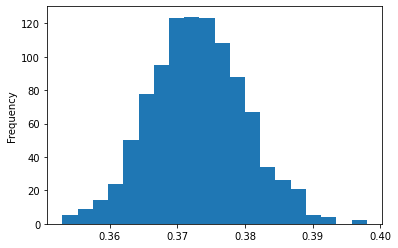

In [31]:
%matplotlib inline
import pandas as pd
pd.Series(deltas).plot.hist(bins=20)